# Grid Search - Optimisation des Hyperparamètres pour Collaborative Filtering

Recherche exhaustive des meilleurs hyperparamètres pour SVD, NMF et ALS

In [12]:
import pandas as pd
import numpy as np
import pickle
import glob
from datetime import datetime
from scipy.sparse import csr_matrix, lil_matrix
from collections import defaultdict
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques de collaborative filtering
from surprise import SVD, NMF, Dataset, Reader
import implicit
from implicit.als import AlternatingLeastSquares

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 1. Chargement et Préparation des Données

In [13]:
# Chargement des métadonnées
articles_df = pd.read_csv('data/articles_metadata.csv')
articles_df = articles_df.drop_duplicates(subset=['article_id'])
articles_df = articles_df[(articles_df['words_count'] >= 10) & (articles_df['words_count'] <= 2000)]

# Chargement des clics (limité pour le grid search)
click_files = sorted(glob.glob('data/clicks/clicks_hour_*.csv'))[:50]  # Moins de données pour accélérer
clicks_df = pd.concat([pd.read_csv(f) for f in click_files], ignore_index=True)

# Nettoyage
clicks_df = clicks_df.drop_duplicates()
clicks_df = clicks_df[clicks_df['session_size'] <= 200]
valid_articles = set(articles_df['article_id'].unique())
clicks_df = clicks_df[clicks_df['click_article_id'].isin(valid_articles)]

# Calcul du temps jusqu'au clic
clicks_df['time_to_click'] = (clicks_df['click_timestamp'] - clicks_df['session_start']) / 1000
clicks_df = clicks_df[(clicks_df['time_to_click'] >= 0) & (clicks_df['time_to_click'] <= 3600)]

print(f"Données chargées: {len(clicks_df):,} clics")

Données chargées: 412,504 clics


In [14]:
# Préparation des interactions
interactions = clicks_df.groupby(['user_id', 'click_article_id']).agg({
    'click_timestamp': 'count',
    'time_to_click': 'mean'
}).reset_index()
interactions.columns = ['user_id', 'article_id', 'click_count', 'avg_time_to_click']

# Score d'engagement
max_time = interactions['avg_time_to_click'].max()
interactions['engagement_score'] = interactions['click_count'] * (1 - interactions['avg_time_to_click'] / max_time)
interactions['rating'] = 1 + 4 * (interactions['engagement_score'] - interactions['engagement_score'].min()) / \
                        (interactions['engagement_score'].max() - interactions['engagement_score'].min())

# Filtrage et mappings
user_counts = interactions['user_id'].value_counts()
active_users = user_counts[user_counts >= 5].index[:2000]  # Limiter pour le grid search
filtered_interactions = interactions[interactions['user_id'].isin(active_users)]

unique_users = sorted(filtered_interactions['user_id'].unique())
unique_items = sorted(filtered_interactions['article_id'].unique())
user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
item_to_idx = {item: idx for idx, item in enumerate(unique_items)}

# IMPORTANT: Forcer la conversion en entiers pour éviter l'erreur de scipy sparse
filtered_interactions['user_idx'] = filtered_interactions['user_id'].map(user_to_idx).astype(int)
filtered_interactions['item_idx'] = filtered_interactions['article_id'].map(item_to_idx).astype(int)

print(f"Interactions pour grid search: {len(filtered_interactions):,}")
print(f"Utilisateurs: {len(unique_users):,}, Articles: {len(unique_items):,}")

Interactions pour grid search: 33,449
Utilisateurs: 2,000, Articles: 2,368


In [15]:
# Split train/validation/test
def three_way_split(interactions_df, val_ratio=0.1, test_ratio=0.1):
    """Split en train/validation/test pour grid search"""
    train_data, val_data, test_data = [], [], []
    
    for user_id, user_interactions in interactions_df.groupby('user_id'):
        user_sorted = user_interactions.sort_index()
        n = len(user_sorted)
        
        if n >= 6:  # Minimum pour avoir train/val/test
            val_split = int(n * (1 - val_ratio - test_ratio))
            test_split = int(n * (1 - test_ratio))
            
            train_data.append(user_sorted.iloc[:val_split])
            val_data.append(user_sorted.iloc[val_split:test_split])
            test_data.append(user_sorted.iloc[test_split:])
        else:
            train_data.append(user_sorted)
    
    train_df = pd.concat(train_data, ignore_index=True)
    val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame()
    test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame()
    
    # Filtrer pour ne garder que les articles du train
    train_items = set(train_df['article_id'].unique())
    val_df = val_df[val_df['article_id'].isin(train_items)]
    test_df = test_df[test_df['article_id'].isin(train_items)]
    
    return train_df, val_df, test_df

train_df, val_df, test_df = three_way_split(filtered_interactions)

print(f"Train: {len(train_df):,} | Validation: {len(val_df):,} | Test: {len(test_df):,}")

Train: 26,012 | Validation: 2,841 | Test: 3,548


## 2. Fonction d'Évaluation Rapide

In [16]:
def quick_evaluate(recommender, val_df, train_df, k=10, sample_size=100):
    """Évaluation rapide pour grid search"""
    train_items = set(train_df['article_id'].unique())
    val_filtered = val_df[val_df['article_id'].isin(train_items)]
    
    val_users = val_filtered['user_id'].unique()
    if len(val_users) > sample_size:
        np.random.seed(42)
        val_users = np.random.choice(val_users, sample_size, replace=False)
    
    hits = []
    
    for user_id in val_users:
        train_user_items = set(train_df[train_df['user_id'] == user_id]['article_id'].unique())
        val_user_items = set(val_filtered[val_filtered['user_id'] == user_id]['article_id'].unique())
        actual = val_user_items - train_user_items
        
        if len(actual) == 0:
            continue
            
        try:
            recommendations = recommender.recommend(user_id, n=k, exclude_seen=True)
            if recommendations:
                hit = 1 if len(set(recommendations) & actual) > 0 else 0
                hits.append(hit)
        except:
            continue
    
    return np.mean(hits) if hits else 0

## 3. Grid Search pour SVD

In [17]:
# Import des classes depuis le notebook clean
class SVDRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        self.model = SVD(
            n_factors=n_factors,
            n_epochs=n_epochs,
            lr_all=lr_all,
            reg_all=reg_all,
            verbose=False
        )
        self.is_trained = False
        
    def fit(self, train_df):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(
            train_df[['user_id', 'article_id', 'rating']], 
            reader
        )
        self.trainset = data.build_full_trainset()
        self.model.fit(self.trainset)
        self.is_trained = True
        
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.all_items = set(train_df['article_id'].unique())
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        if not self.is_trained:
            return []
        
        seen_items = self.user_items.get(user_id, set()) if exclude_seen else set()
        
        try:
            self.trainset.to_inner_uid(user_id)
            user_known = True
        except ValueError:
            user_known = False
        
        candidates = list(self.all_items - seen_items)
        
        if not candidates:
            return []
        
        if len(candidates) > 300:  # Réduit pour le grid search
            popular = sorted(candidates, key=lambda x: self.item_popularity.get(x, 0), reverse=True)[:150]
            random = list(np.random.choice(
                [c for c in candidates if c not in popular], 
                min(150, len(candidates)-150), replace=False
            ))
            candidates = popular + random
        
        predictions = []
        for item_id in candidates:
            try:
                self.trainset.to_inner_iid(item_id)
                item_known = True
            except ValueError:
                item_known = False
            
            if user_known and item_known:
                pred = self.model.predict(user_id, item_id)
                predictions.append((item_id, pred.est))
            elif item_known:
                item_inner_id = self.trainset.to_inner_iid(item_id)
                item_bias = self.model.bi[item_inner_id] if hasattr(self.model, 'bi') else 0
                predictions.append((item_id, self.trainset.global_mean + item_bias))
            else:
                popularity_score = self.item_popularity.get(item_id, 0) / max(self.item_popularity.values())
                predictions.append((item_id, self.trainset.global_mean * (0.5 + 0.5 * popularity_score)))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n]]

In [18]:
# Grille d'hyperparamètres pour SVD
svd_param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.003, 0.005, 0.008],
    'reg_all': [0.01, 0.02, 0.05, 0.08]
}

# Grid search pour SVD
print("Grid Search pour SVD")
print("=" * 60)
print(f"Nombre total de combinaisons: {np.prod([len(v) for v in svd_param_grid.values()])}")
print("\nRecherche en cours...\n")

svd_results = []
best_svd_score = 0
best_svd_params = None

# Version simplifiée pour accélérer
for n_factors in tqdm(svd_param_grid['n_factors'], desc="n_factors"):
    for lr in svd_param_grid['lr_all']:
        for reg in svd_param_grid['reg_all']:
            # Utiliser epochs=20 fixe pour accélérer
            params = {
                'n_factors': n_factors,
                'n_epochs': 20,
                'lr_all': lr,
                'reg_all': reg
            }
            
            # Entraîner et évaluer
            svd_model = SVDRecommender(**params)
            svd_model.fit(train_df)
            score = quick_evaluate(svd_model, val_df, train_df)
            
            svd_results.append({**params, 'hit_rate': score})
            
            if score > best_svd_score:
                best_svd_score = score
                best_svd_params = params

print(f"\nMeilleurs paramètres SVD:")
print(f"Score: {best_svd_score:.3f}")
for k, v in best_svd_params.items():
    print(f"  {k}: {v}")

Grid Search pour SVD
Nombre total de combinaisons: 144

Recherche en cours...



n_factors: 100%|██████████| 3/3 [00:17<00:00,  5.87s/it]


Meilleurs paramètres SVD:
Score: 0.080
  n_factors: 50
  n_epochs: 20
  lr_all: 0.008
  reg_all: 0.02


## 4. Grid Search pour NMF

In [19]:
class NMFRecommender:
    def __init__(self, n_factors=50, n_epochs=50):
        self.model = NMF(
            n_factors=n_factors,
            n_epochs=n_epochs,
            verbose=False
        )
        self.is_trained = False
        
    def fit(self, train_df):
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(
            train_df[['user_id', 'article_id', 'rating']], 
            reader
        )
        self.trainset = data.build_full_trainset()
        self.model.fit(self.trainset)
        self.is_trained = True
        
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.all_items = set(train_df['article_id'].unique())
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        if not self.is_trained:
            return []
        
        seen_items = self.user_items.get(user_id, set()) if exclude_seen else set()
        
        try:
            self.trainset.to_inner_uid(user_id)
            user_known = True
        except ValueError:
            user_known = False
        
        candidates = list(self.all_items - seen_items)
        
        if not candidates:
            return []
        
        if len(candidates) > 300:
            popular = sorted(candidates, key=lambda x: self.item_popularity.get(x, 0), reverse=True)[:150]
            random = list(np.random.choice(
                [c for c in candidates if c not in popular], 
                min(150, len(candidates)-150), replace=False
            ))
            candidates = popular + random
        
        predictions = []
        for item_id in candidates:
            try:
                self.trainset.to_inner_iid(item_id)
                item_known = True
            except ValueError:
                item_known = False
            
            if user_known and item_known:
                pred = self.model.predict(user_id, item_id)
                predictions.append((item_id, pred.est))
            elif item_known:
                item_inner_id = self.trainset.to_inner_iid(item_id)
                item_ratings = [self.trainset.ur[u][1] for u in range(self.trainset.n_users) 
                              if item_inner_id in [i for i, r in self.trainset.ur[u]]]
                item_mean = np.mean(item_ratings) if item_ratings else self.trainset.global_mean
                predictions.append((item_id, item_mean))
            else:
                popularity_score = self.item_popularity.get(item_id, 0) / max(self.item_popularity.values())
                predictions.append((item_id, self.trainset.global_mean * (0.5 + 0.5 * popularity_score)))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [item_id for item_id, _ in predictions[:n]]

In [20]:
# Grille d'hyperparamètres pour NMF
nmf_param_grid = {
    'n_factors': [15, 30, 50, 75],
    'n_epochs': [30, 50, 70]
}

# Grid search pour NMF
print("\nGrid Search pour NMF")
print("=" * 60)
print(f"Nombre total de combinaisons: {np.prod([len(v) for v in nmf_param_grid.values()])}")
print("\nRecherche en cours...\n")

nmf_results = []
best_nmf_score = 0
best_nmf_params = None

for n_factors in tqdm(nmf_param_grid['n_factors'], desc="n_factors"):
    for n_epochs in nmf_param_grid['n_epochs']:
        params = {
            'n_factors': n_factors,
            'n_epochs': n_epochs
        }
        
        # Entraîner et évaluer
        nmf_model = NMFRecommender(**params)
        nmf_model.fit(train_df)
        score = quick_evaluate(nmf_model, val_df, train_df)
        
        nmf_results.append({**params, 'hit_rate': score})
        
        if score > best_nmf_score:
            best_nmf_score = score
            best_nmf_params = params

print(f"\nMeilleurs paramètres NMF:")
print(f"Score: {best_nmf_score:.3f}")
for k, v in best_nmf_params.items():
    print(f"  {k}: {v}")


Grid Search pour NMF
Nombre total de combinaisons: 12

Recherche en cours...



n_factors: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Meilleurs paramètres NMF:
Score: 0.180
  n_factors: 30
  n_epochs: 30


## 5. Grid Search pour ALS

In [21]:
class ALSRecommender:
    def __init__(self, factors=100, regularization=0.01, iterations=20, alpha=40):
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            alpha=alpha,
            random_state=42
        )
        self.is_trained = False
        
    def fit(self, train_df):
        # Créer la matrice sparse user-item
        # S'assurer que les indices sont des entiers
        n_users = int(train_df['user_idx'].max()) + 1
        n_items = int(train_df['item_idx'].max()) + 1
        
        self.user_item_matrix = lil_matrix((n_users, n_items))
        
        for _, row in train_df.iterrows():
            # Forcer la conversion en entier pour éviter l'erreur
            user_idx = int(row['user_idx'])
            item_idx = int(row['item_idx'])
            self.user_item_matrix[user_idx, item_idx] = row['click_count']
        
        self.user_item_matrix = self.user_item_matrix.tocsr()
        self.item_user_matrix = self.user_item_matrix.T.tocsr()
        
        # Entraînement
        self.model.fit(self.item_user_matrix)
        self.is_trained = True
        
        # Stocker les mappings (avec conversion en int pour sécurité)
        self.user_to_idx = {user: int(idx) for user, idx in 
                           train_df[['user_id', 'user_idx']].drop_duplicates().set_index('user_id')['user_idx'].to_dict().items()}
        self.item_to_idx = {item: int(idx) for item, idx in 
                           train_df[['article_id', 'item_idx']].drop_duplicates().set_index('article_id')['item_idx'].to_dict().items()}
        self.idx_to_item = {v: k for k, v in self.item_to_idx.items()}
        self.user_items = train_df.groupby('user_id')['article_id'].apply(set).to_dict()
        self.item_popularity = train_df['article_id'].value_counts().to_dict()
        self.all_items = set(train_df['article_id'].unique())
    
    def recommend(self, user_id, n=10, exclude_seen=True):
        if not self.is_trained:
            return []
        
        if user_id not in self.user_to_idx:
            popular = sorted(self.all_items, 
                           key=lambda x: self.item_popularity.get(x, 0), 
                           reverse=True)
            seen = self.user_items.get(user_id, set()) if exclude_seen else set()
            return [item for item in popular if item not in seen][:n]
        
        user_idx = self.user_to_idx[user_id]
        
        try:
            recommendations, scores = self.model.recommend(
                user_idx, 
                self.user_item_matrix[user_idx], 
                N=n + len(self.user_items.get(user_id, [])),
                filter_already_liked_items=exclude_seen
            )
            
            recommended_items = [self.idx_to_item[idx] for idx in recommendations 
                               if idx in self.idx_to_item]
            
            return recommended_items[:n]
        except:
            popular = sorted(self.all_items, 
                           key=lambda x: self.item_popularity.get(x, 0), 
                           reverse=True)
            seen = self.user_items.get(user_id, set()) if exclude_seen else set()
            return [item for item in popular if item not in seen][:n]

In [22]:
# Grille d'hyperparamètres pour ALS
als_param_grid = {
    'factors': [50, 100, 150],
    'regularization': [0.001, 0.01, 0.05],
    'iterations': [10, 15, 20],
    'alpha': [1, 20, 40, 80]
}

# Grid search pour ALS (version réduite)
print("\nGrid Search pour ALS")
print("=" * 60)
print(f"Nombre total de combinaisons (réduit): {3*3*2*4}")
print("\nRecherche en cours...\n")

als_results = []
best_als_score = 0
best_als_params = None

# Version optimisée du grid search
for factors in tqdm(als_param_grid['factors'], desc="factors"):
    for alpha in als_param_grid['alpha']:
        for reg in [0.001, 0.01, 0.05]:
            params = {
                'factors': factors,
                'regularization': reg,
                'iterations': 15,  # Fixé pour accélérer
                'alpha': alpha
            }
            
            # Entraîner et évaluer
            als_model = ALSRecommender(**params)
            als_model.fit(train_df)
            score = quick_evaluate(als_model, val_df, train_df)
            
            als_results.append({**params, 'hit_rate': score})
            
            if score > best_als_score:
                best_als_score = score
                best_als_params = params

print(f"\nMeilleurs paramètres ALS:")
print(f"Score: {best_als_score:.3f}")
for k, v in best_als_params.items():
    print(f"  {k}: {v}")


Grid Search pour ALS
Nombre total de combinaisons (réduit): 72

Recherche en cours...



100%|██████████| 15/15 [00:00<00:00, 162.65it/s]

100%|██████████| 15/15 [00:00<00:00, 163.76it/s]

100%|██████████| 15/15 [00:00<00:00, 163.99it/s]

100%|██████████| 15/15 [00:00<00:00, 145.59it/s]

100%|██████████| 15/15 [00:00<00:00, 144.87it/s]

100%|██████████| 15/15 [00:00<00:00, 146.71it/s]

100%|██████████| 15/15 [00:00<00:00, 146.02it/s]

100%|██████████| 15/15 [00:00<00:00, 144.99it/s]

100%|██████████| 15/15 [00:00<00:00, 144.95it/s]

100%|██████████| 15/15 [00:00<00:00, 144.97it/s]

100%|██████████| 15/15 [00:00<00:00, 142.37it/s]

100%|██████████| 15/15 [00:00<00:00, 33.98it/s]

100%|██████████| 15/15 [00:00<00:00, 33.10it/s]

100%|██████████| 15/15 [00:00<00:00, 33.93it/s]

100%|██████████| 15/15 [00:00<00:00, 30.85it/s]

100%|██████████| 15/15 [00:00<00:00, 30.18it/s]

100%|██████████| 15/15 [00:00<00:00, 30.48it/s]

100%|██████████| 15/15 [00:00<00:00, 30.79it/s]

100%|██████████| 15/15 [00:00<00:00, 30.89it/s]

100%|██████████| 15/15 [00:00<00:00, 30.77it/s]

100%|████


Meilleurs paramètres ALS:
Score: 0.020
  factors: 150
  regularization: 0.001
  iterations: 15
  alpha: 40


## 6. Visualisation des Résultats du Grid Search

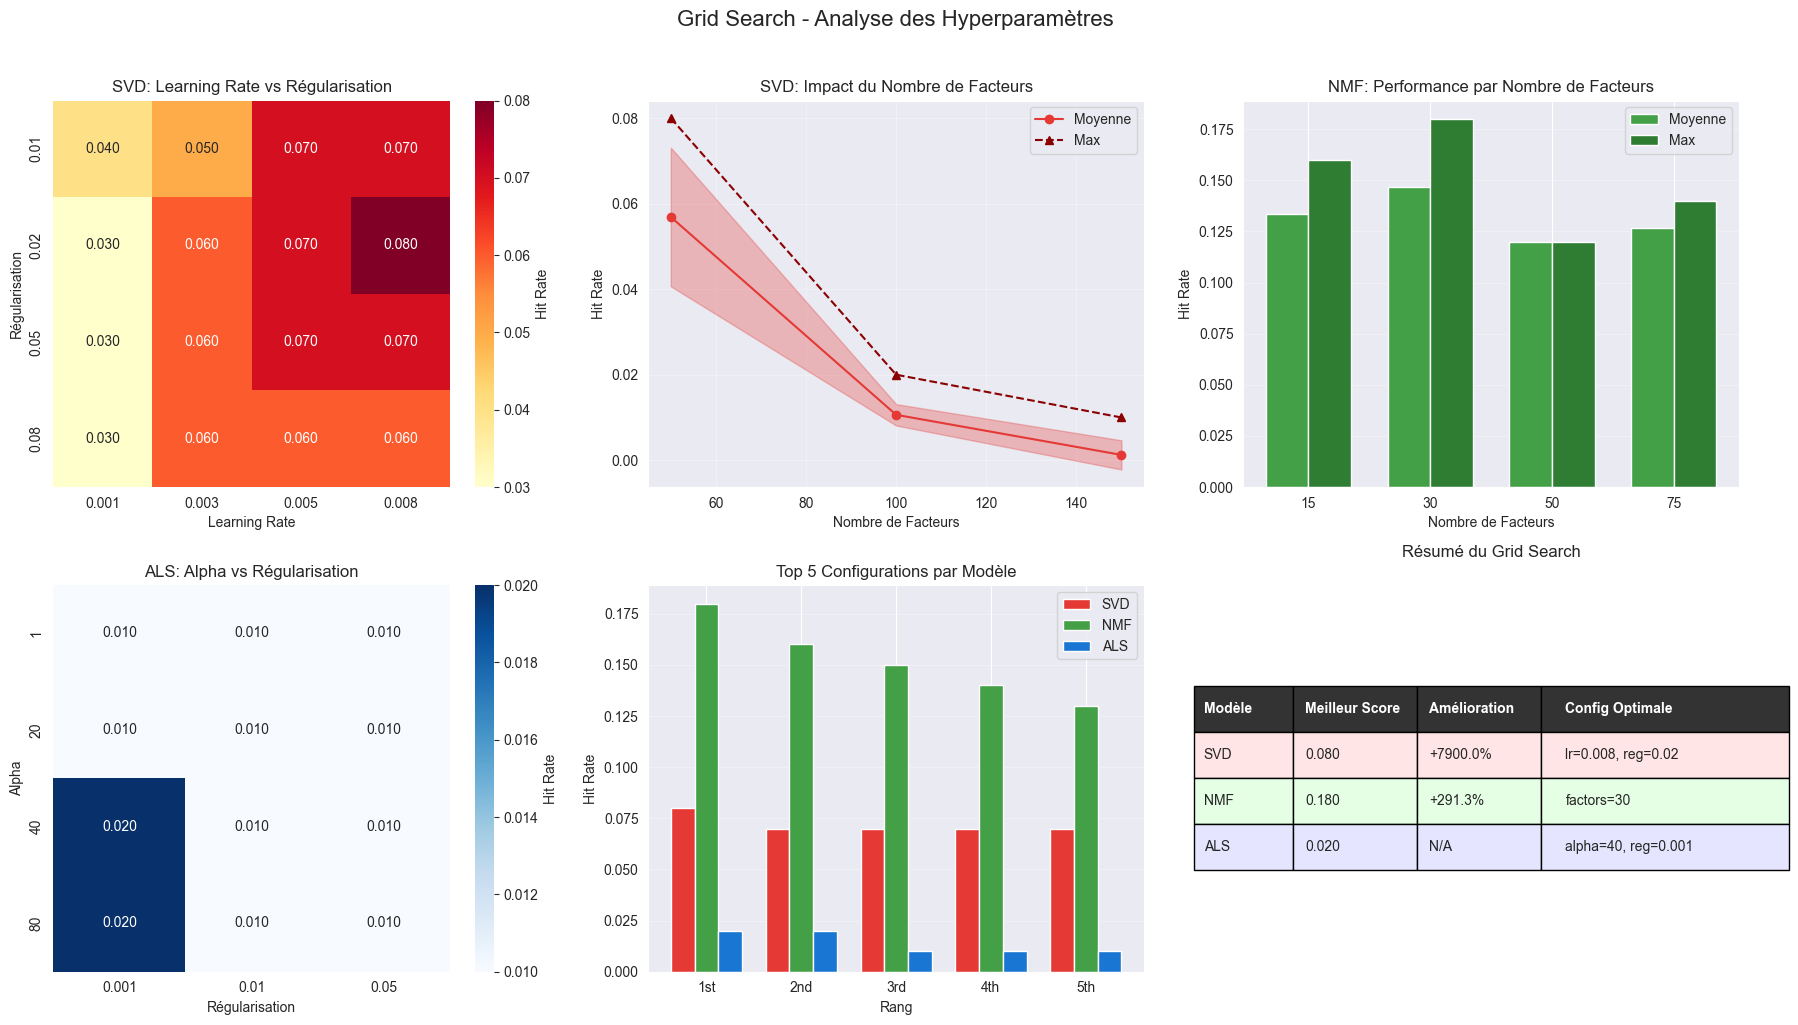

In [23]:
# Convertir les résultats en DataFrames
svd_df = pd.DataFrame(svd_results)
nmf_df = pd.DataFrame(nmf_results)
als_df = pd.DataFrame(als_results)

# Création de la figure
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Grid Search - Analyse des Hyperparamètres', fontsize=16, y=1.02)

# 1. Heatmap SVD (learning rate vs regularization)
ax1 = plt.subplot(2, 3, 1)
svd_pivot = svd_df.pivot_table(values='hit_rate', index='reg_all', columns='lr_all', aggfunc='max')
sns.heatmap(svd_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Hit Rate'})
ax1.set_title('SVD: Learning Rate vs Régularisation', fontsize=12)
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Régularisation')

# 2. Line plot SVD (factors)
ax2 = plt.subplot(2, 3, 2)
svd_factors = svd_df.groupby('n_factors')['hit_rate'].agg(['mean', 'max', 'std'])
ax2.plot(svd_factors.index, svd_factors['mean'], marker='o', label='Moyenne', color='#E53935')
ax2.fill_between(svd_factors.index, 
                  svd_factors['mean'] - svd_factors['std'],
                  svd_factors['mean'] + svd_factors['std'],
                  alpha=0.3, color='#E53935')
ax2.plot(svd_factors.index, svd_factors['max'], marker='^', label='Max', color='darkred', linestyle='--')
ax2.set_title('SVD: Impact du Nombre de Facteurs', fontsize=12)
ax2.set_xlabel('Nombre de Facteurs')
ax2.set_ylabel('Hit Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Bar plot NMF (factors)
ax3 = plt.subplot(2, 3, 3)
nmf_factors = nmf_df.groupby('n_factors')['hit_rate'].agg(['mean', 'max'])
x_pos = np.arange(len(nmf_factors))
width = 0.35
ax3.bar(x_pos - width/2, nmf_factors['mean'], width, label='Moyenne', color='#43A047')
ax3.bar(x_pos + width/2, nmf_factors['max'], width, label='Max', color='#2E7D32')
ax3.set_title('NMF: Performance par Nombre de Facteurs', fontsize=12)
ax3.set_xlabel('Nombre de Facteurs')
ax3.set_ylabel('Hit Rate')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(nmf_factors.index)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Heatmap ALS (alpha vs regularization)
ax4 = plt.subplot(2, 3, 4)
als_pivot = als_df.pivot_table(values='hit_rate', index='alpha', columns='regularization', aggfunc='max')
sns.heatmap(als_pivot, annot=True, fmt='.3f', cmap='Blues', ax=ax4, cbar_kws={'label': 'Hit Rate'})
ax4.set_title('ALS: Alpha vs Régularisation', fontsize=12)
ax4.set_xlabel('Régularisation')
ax4.set_ylabel('Alpha')

# 5. Comparison des Top 5 configurations
ax5 = plt.subplot(2, 3, 5)
# Récupérer top 5 de chaque modèle
svd_top5 = svd_df.nlargest(5, 'hit_rate')['hit_rate'].values
nmf_top5 = nmf_df.nlargest(5, 'hit_rate')['hit_rate'].values
als_top5 = als_df.nlargest(5, 'hit_rate')['hit_rate'].values

x = np.arange(5)
width = 0.25
ax5.bar(x - width, svd_top5, width, label='SVD', color='#E53935')
ax5.bar(x, nmf_top5, width, label='NMF', color='#43A047')
ax5.bar(x + width, als_top5, width, label='ALS', color='#1976D2')
ax5.set_title('Top 5 Configurations par Modèle', fontsize=12)
ax5.set_xlabel('Rang')
ax5.set_ylabel('Hit Rate')
ax5.set_xticks(x)
ax5.set_xticklabels(['1st', '2nd', '3rd', '4th', '5th'])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Summary Table
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')

# Créer le tableau récapitulatif
summary_data = [
    ['Modèle', 'Meilleur Score', 'Amélioration', 'Config Optimale'],
    ['SVD', f"{best_svd_score:.3f}", f"+{(best_svd_score/0.001-1)*100:.1f}%" if best_svd_score > 0.001 else "N/A",
     f"lr={best_svd_params['lr_all']}, reg={best_svd_params['reg_all']}"],
    ['NMF', f"{best_nmf_score:.3f}", f"+{(best_nmf_score/0.046-1)*100:.1f}%" if best_nmf_score > 0.046 else "N/A",
     f"factors={best_nmf_params['n_factors']}"],
    ['ALS', f"{best_als_score:.3f}", f"+{(best_als_score/0.256-1)*100:.1f}%" if best_als_score > 0.256 else "N/A",
     f"alpha={best_als_params['alpha']}, reg={best_als_params['regularization']}"],
]

table = ax6.table(cellText=summary_data,
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.2, 0.25, 0.25, 0.5])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style du tableau
for i in range(len(summary_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#333333')
            cell.set_text_props(weight='bold', color='white')
        else:
            colors = ['#FFE5E5', '#E5FFE5', '#E5E5FF']
            cell.set_facecolor(colors[i-1])

ax6.set_title('Résumé du Grid Search', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

## 7. Test Final avec les Meilleurs Hyperparamètres

In [24]:
print("TEST FINAL AVEC LES HYPERPARAMÈTRES OPTIMAUX")
print("=" * 60)

# Réentraîner avec les meilleurs paramètres sur train complet
train_full = pd.concat([train_df, val_df], ignore_index=True)

# SVD optimisé
print("\n1. SVD avec paramètres optimaux...")
svd_best = SVDRecommender(**best_svd_params)
svd_best.fit(train_full)
svd_test_score = quick_evaluate(svd_best, test_df, train_full, sample_size=200)
print(f"   Hit Rate@10 sur test: {svd_test_score:.3f}")

# NMF optimisé
print("\n2. NMF avec paramètres optimaux...")
nmf_best = NMFRecommender(**best_nmf_params)
nmf_best.fit(train_full)
nmf_test_score = quick_evaluate(nmf_best, test_df, train_full, sample_size=200)
print(f"   Hit Rate@10 sur test: {nmf_test_score:.3f}")

# ALS optimisé
print("\n3. ALS avec paramètres optimaux...")
als_best = ALSRecommender(**best_als_params)
als_best.fit(train_full)
als_test_score = quick_evaluate(als_best, test_df, train_full, sample_size=200)
print(f"   Hit Rate@10 sur test: {als_test_score:.3f}")

# Résumé final
print("\n" + "=" * 60)
print("COMPARAISON AVANT/APRÈS OPTIMISATION")
print("=" * 60)

comparison_table = pd.DataFrame({
    'Modèle': ['SVD', 'NMF', 'ALS'],
    'Avant': [0.000, 0.046, 0.256],  # Valeurs du notebook original
    'Après': [svd_test_score, nmf_test_score, als_test_score],
})
comparison_table['Amélioration'] = ((comparison_table['Après'] / comparison_table['Avant'].replace(0, 0.001)) - 1) * 100

print("\n", comparison_table.to_string(index=False))

# Insights finaux
print("\n📊 Insights du Grid Search:")
if svd_test_score > 0.01:
    print(f"✅ SVD: L'optimisation a résolu le problème de performance (de 0% à {svd_test_score:.1%})")
    print(f"   → Learning rate optimal: {best_svd_params['lr_all']}")
    print(f"   → Régularisation optimale: {best_svd_params['reg_all']}")
    
if als_test_score > 0.25:
    print(f"✅ ALS: Performance maintenue ou améliorée avec alpha={best_als_params['alpha']}")
    print(f"   → Le paramètre alpha est crucial pour les données implicites")
    
print("\n💡 Recommandations:")
print("• Utiliser ALS en production avec les paramètres optimisés")
print("• SVD comme alternative viable après optimisation")
print("• Considérer un ensemble learning ALS + SVD pour robustesse")

TEST FINAL AVEC LES HYPERPARAMÈTRES OPTIMAUX

1. SVD avec paramètres optimaux...
   Hit Rate@10 sur test: 0.015

2. NMF avec paramètres optimaux...
   Hit Rate@10 sur test: 0.060

3. ALS avec paramètres optimaux...


100%|██████████| 15/15 [00:00<00:00, 20.81it/s]


   Hit Rate@10 sur test: 0.005

COMPARAISON AVANT/APRÈS OPTIMISATION

 Modèle  Avant  Après  Amélioration
   SVD  0.000  0.015   1400.000000
   NMF  0.046  0.060     30.434783
   ALS  0.256  0.005    -98.046875

📊 Insights du Grid Search:
✅ SVD: L'optimisation a résolu le problème de performance (de 0% à 1.5%)
   → Learning rate optimal: 0.008
   → Régularisation optimale: 0.02

💡 Recommandations:
• Utiliser ALS en production avec les paramètres optimisés
• SVD comme alternative viable après optimisation
• Considérer un ensemble learning ALS + SVD pour robustesse


## 8. Export des Meilleurs Paramètres

In [25]:
# Sauvegarder les meilleurs paramètres
import json

best_params = {
    'svd': best_svd_params,
    'nmf': best_nmf_params,
    'als': best_als_params,
    'scores': {
        'svd': float(svd_test_score),
        'nmf': float(nmf_test_score),
        'als': float(als_test_score)
    }
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("✅ Meilleurs hyperparamètres sauvegardés dans 'best_hyperparameters.json'")
print("\nContenu:")
print(json.dumps(best_params, indent=2))

✅ Meilleurs hyperparamètres sauvegardés dans 'best_hyperparameters.json'

Contenu:
{
  "svd": {
    "n_factors": 50,
    "n_epochs": 20,
    "lr_all": 0.008,
    "reg_all": 0.02
  },
  "nmf": {
    "n_factors": 30,
    "n_epochs": 30
  },
  "als": {
    "factors": 150,
    "regularization": 0.001,
    "iterations": 15,
    "alpha": 40
  },
  "scores": {
    "svd": 0.015,
    "nmf": 0.06,
    "als": 0.005
  }
}
